In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
# import pandas as pd

import quickplot as qp

# Map projection and its implications
In this session we continue our exploration of `geopandas` and also examine an important issue concerning spatial data, that of map projection, which can often be overlooked especially when starting out with spatial data.

In [20]:
counties1 = gpd.read_file('ca-counties.shp')
counties2 = gpd.read_file('ca-counties-LL.shp')

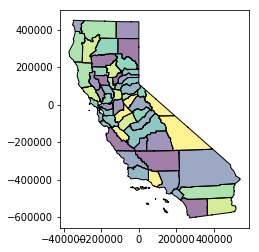

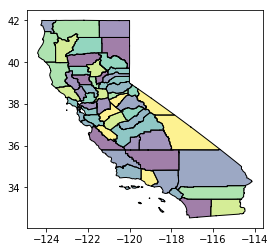

In [21]:
counties1.plot()
counties2.plot()

These two datasets are both county-level data for California as used in the previous session.
Check the data tables to confirm this.

Why do they look different? The difference is in their *projections*. The first is in a projected coordinate system *California Equal Area Albers* while the second is in simple latitude-longitude coordinates.

Location on Earth's surface is recorded in latitude and longitude.  Each is an angular measure relative to two imaginary references, the **Equator** (latitude = 0&deg;) and the **Prime Meridian** through Greenwich in London (longitude = 0&deg;). This system of geolocation makes sense because Earth is not flat (duh!) but a globe. The measurement system is shown in the figure below.

<img src='latlong.png' width="400">

Given a pair of coordinates we are accustomed to plotting them on $(x,y)$ axes, but when we do this with latitude and longitude coordinate pairs, we get ourselves in trouble, because although **parallels** (lines at equal latitude) are equally spaced from the equator to the poles, **meridians** converge toward the poles due to the (approximately) spherical shape of Earth.

Put more simply, the coordinate system we use to record location on Earth's three-dimensional surface can't be used directly to plot two-dimensional (flat) maps on paper or on screens. Or more correctly, it *can* be used but over any significant area of Earth surface substantial distortions will result.

To resolve this problem, we **project** latitude-longitude coordinates into other coordinate systems that have desired properties for particular mapping or analytical purposes.

This is a highly technical, yet fascinating area.  We don't have time to get into it in any detail in this class, but it is important to appreciate the implications.  The most important of these is that we need to know projection is a thing!  The second is that **there is no perfect projection** just different projections that we might prefer for different purposes.  Of particular importance are **equal-area** projections, which preserve the relative area of regions on Earth surface and **conformal** projections which preserve shape.  Any given projection can only be effective over a limited area of Earth surface (where the approximation to a flat plane is adequate).

Projected data are particularly useful because they make calculation of distances and areas much simpler (we can apply simple geometry) than if we work with latitude-longitude coordinates.  For example, the equation for the distance between two locations with lat-lon coordinates $\left(\phi_1,\lambda_1\right)$ and $\left(\phi_2,\lambda_2\right)$ is given by (see [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula). 

$$ 
d=2 r \arcsin\left(\sqrt{\sin^2\left(\frac{\varphi_2 - \varphi_1}{2}\right) + \cos(\varphi_1) \cos(\varphi_2)\sin^2\left(\frac{\lambda_2 - \lambda_1}{2}\right)}\right)
$$

where $r$ is Earth's radius. On the other hand, if we work in projected $\left(x,y\right)$ coordinates in the plane, then we can use the much simpler

$$
d\approx\sqrt{(x_2-x_1)^2+(y_2-y_1)^2}
$$

This provides enormous computational benefits when we are calculating many distances and areas in carrying out spatial analysis.

## Map projections in geopandas
The data we read in above were differently projected. We can see how with the `crs` property of the `GeoDataFrame`s.

In [23]:
counties1.crs, counties2.crs

({'datum': 'NAD83',
  'lat_0': 0,
  'lat_1': 34,
  'lat_2': 40.5,
  'lon_0': -120,
  'no_defs': True,
  'proj': 'aea',
  'units': 'm',
  'x_0': 0,
  'y_0': -4000000},
 {'init': 'epsg:4326'})

The first one is detailed information that enables lat-lon to be projected into the coordinate system of interest. We can see (with a little practice) that this is a projection that is equal-area ('aea'), which results in coordinates in meters (`'units': 'm'`). The other projection isn't giving a lot away, other than that it has an EPSG code 4326.  You can look that up [here](http://epsg.io/4326) for more information.

There are literally hundreds, probably thousands of projected coordinate systems. California has 6 local projected coordinate systems (State Plane 1 through 6) and every country and many subnational jurisdictions have their own localize projected coordinate systems used of precision mapping in those jurisdictions.

For our purposes, the important thing is to be able to manipulate projected coordinate systems, for which we use the `to_crs()` function. If you know something about the projection then this is easy, and with just a single line of code we can reproject convert a given `GeoDataFrame` to a required new projection.

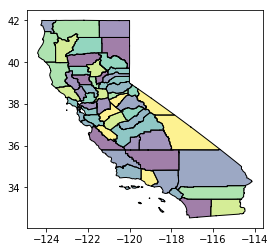

In [25]:
counties1.to_crs(epsg=4326).plot()

Note that this does not change the coordinate system of `counties1`.  To do that, we have to save it back to the variable name:

In [27]:
counties1 = counties1.to_crs(epsg=4326)

You get some idea of the variety of projected coordinate systems available from [this useful website](http://www.progonos.com/furuti/MapProj/Normal/TOC/cartTOC.html).  As is evident from that site, projection becomes especially important when we want to make maps of the whole Earth, because it is then that the distorting effects of the difference between a (near) sphere and a flat map become most problematic.

## Playing with world map projections

Try each of the following, until you get a feel for the possibilities.

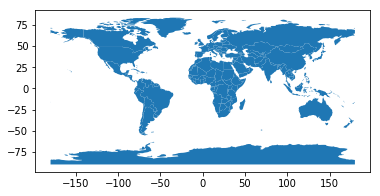

In [30]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
qp.quickplot(world)

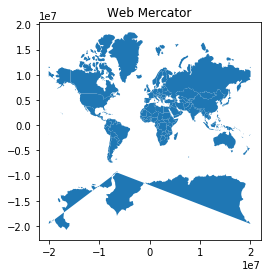

In [46]:
## This one is 'Web Mercator' popularized by web mapping, and much 
## disliked by cartographers for its large distortions of areas 
## toward the poles
plt.gca().set_title('Web Mercator')
qp.quickplot(world.to_crs(epsg=3857))

To get a sense of just how bad the distortions caused by Mercator are check out [thetruesize.com](http://thetruesize.com).

It is not uncommon with world data sets to run into problems like the one we see above with Antarctica - this is because how coordinates are handled when longitude transitions from -180&deg; to +180&deg; is often poorly specified.  To avoid this problem we can remove Antarctica. Check out the data table.

In [33]:
world.head()

,continent,gdp_md_est,geometry,iso_a3,name,pop_est
0,Asia,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",AFG,Afghanistan,28400000.0
1,Africa,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...,AGO,Angola,12799293.0
2,Europe,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",ALB,Albania,3639453.0
3,Asia,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,...",ARE,United Arab Emirates,4798491.0
4,South America,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...,ARG,Argentina,40913584.0


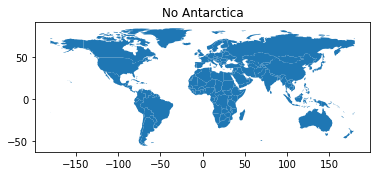

In [44]:
world2 = world[world.continent != 'Antarctica']
plt.gca().set_title('No Antarctica')
qp.quickplot(world2)

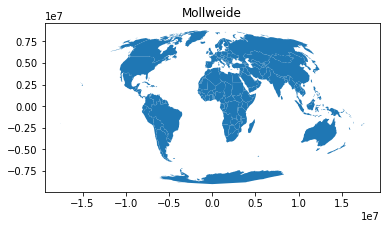

In [45]:
plt.gca().set_title('Mollweide')
qp.quickplot(world.to_crs('+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'))

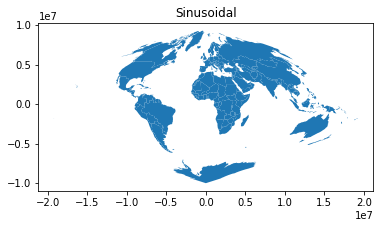

In [47]:
plt.gca().set_title('Sinusoidal')
qp.quickplot(world.to_crs('+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6378140 +b=6356750 +units=m +no_defs'))

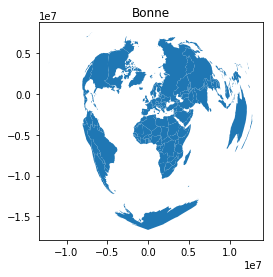

In [48]:
plt.gca().set_title('Bonne')
qp.quickplot(world.to_crs('+proj=bonne +lon_0=0 +lat_1=60 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'))

## How it matters&mdash;counting points in polygons
A concrete example of how much these things matter is provided by any attempt to perform operations dependent on accurate measurement of distance or area, and it is on this that we will focus in the remained of this session and in the assignment to be turned in this week.

In [ ]:
quakes = gpd.read_file('earthquakes.shp')

In [149]:
quakes['count'] = 1
quakes.head()

,DAY,DEATHS,EQ_PRIMARY,FLAG_TSUNA,FOCAL_DEPT,I_D,LATITUDE,LONGITUDE,MONTH,YEAR,geometry,count
0,11,None,7.8,None,None,2566,36.5,133.5,1,1900,POINT (133.5 36.5),1
1,20,None,7.4,None,10.000000,2569,20.0,-105.0,1,1900,POINT (-105 20),1
2,16,None,7.8,None,60.000000,2571,20.0,-105.0,5,1900,POINT (-105 20),1
3,21,None,7.5,None,60.000000,2573,10.0,-85.5,6,1900,POINT (-85.5 10),1
4,29,None,7.6,None,33.000000,2575,-10.0,165.0,7,1900,POINT (165 -10),1


In [223]:
import shapely.geometry
import math

# makes hex centers for the specified bounding box and number of rows
def make_centers(xmin=-180, xmax=180, ymin=-85, ymax=85, nrows=10):
    row_spacing = (ymax - ymin) / nrows
    col_spacing = 2 / math.sqrt(3) * row_spacing
    ncols = (xmax - xmin) / col_spacing
    x = []
    y = []
    for r in range(int(nrows + 0.5)):
        offset = 0.5 * (r % 2)
        x += [(c + 0.25 + offset) * col_spacing + xmin for c in range(int(ncols + 0.5))] 
        y += [(r + 0.5) * row_spacing + ymin] * int(ncols + 0.5)
    return (x, y)

# makes hexagons returning a list of shapely.geometry.polygon.Polygons
# first calls make_centers to determine hexagon centers 
def make_hexes(xmin=-175, xmax=175, ymin=-85, ymax=85, nrows=10):
    centers = make_centers(xmin, xmax, ymin, ymax, nrows)
    radius = (centers[0][1] - centers[0][0]) / math.sqrt(3)
    hexes = []
    for (x, y) in zip(centers[0], centers[1]):
        this_hex = []
        for theta in [(1/6 + i/3) * math.pi for i in range(6)]:
            this_hex.append((x + radius * math.cos(theta), y + radius * math.sin(theta)))
        hexes.append(shapely.geometry.polygon.Polygon(this_hex))
    return hexes

def get_hexbins(pts, nrows=10):
    import geopandas as gpd
    
    b = pts.bounds
    hexes = gpd.GeoSeries(make_hexes(nrows=nrows, 
                                     xmin=min(b.minx), 
                                     xmax=max(b.maxx), 
                                     ymin=min(b.miny), 
                                     ymax=max(b.maxy)))
    hexes.crs = pts.crs
    return gpd.GeoDataFrame(geometry=hexes)

def hexbin_density(pts, nrows=10):
    pts['count'] = 1
    hb = get_hexbins(pts, nrows=10)
    p_counts = gpd.sjoin(pts, hb, how='inner', 
                         op='within')[['index_right', 'count']].groupby(['index_right'], as_index=False).sum()
    p_density = hb.merge(p_counts, how='inner', left_index=True, right_on='index_right')[['geometry', 'count']]
    return p_density, hb

In [224]:
quake_density, hexbins = hexbin_density(quakes, nrows=15)

fig, ax = plt.subplots(figsize=(12,6))
ax.set_aspect('equal')
hexbins.plot(ax=ax, facecolor='w', edgecolor='k', linewidth=0.1)
quake_density.plot(ax=ax, column='count', scheme='quantiles', cmap='Reds', linewidth=0.1)
quakes.plot(ax=ax, color='k')

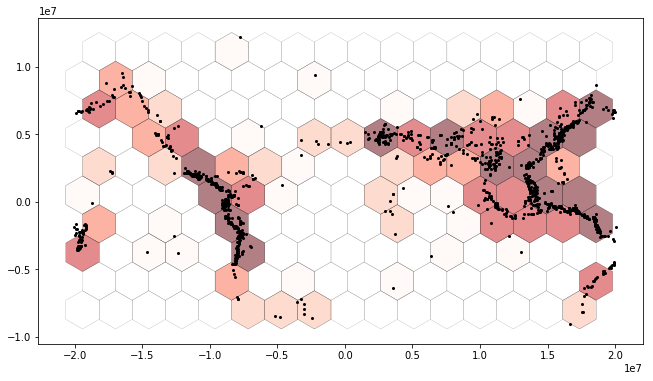

In [228]:
quake_density, hexbins = hexbin_density(quakes.to_crs(epsg=3857), nrows=15)

fig, ax = plt.subplots(figsize=(12,6))
ax.set_aspect('equal')
hexbins.plot(ax=ax, facecolor='w', edgecolor='k', linewidth=0.1)
quake_density.plot(ax=ax, column='count', scheme='quantiles', cmap='Reds', linewidth=0.1)
quakes.to_crs(epsg=3857).plot(ax=ax, color='k')

In [100]:
extent = shapely.geometry.polygon.Polygon([[-179,-80], [-179,80], [179,80], [179,-80]])

In [101]:
extent = gpd.GeoSeries([extent])
extent.crs = {'init' :'epsg:4326'}
world = gpd.GeoDataFrame(geometry=extent)

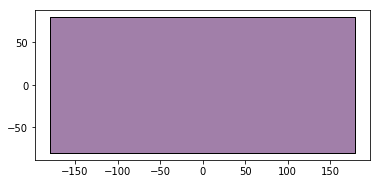

In [102]:
world.plot()

In [109]:
bb = quakes.bounds
min(bb.minx), max(bb.maxx), min(bb.miny), max(bb.maxy)

(-179.98400000000001, 180.0, -62.877000000000002, 73.122)

In [131]:
7 % 4

3

In [219]:
int(9.6)

9